In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras import layers

# Load the dataset
data = pd.read_csv('gas_turbines.csv')

data = data.dropna()

numerical_features = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO', 'NOX']

In [2]:
print(data.describe())

                 AT           AP            AH          AFDP          GTEP  \
count  15039.000000  15039.00000  15039.000000  15039.000000  15039.000000   
mean      17.764381   1013.19924     79.124174      4.200294     25.419061   
std        7.574323      6.41076     13.793439      0.760197      4.173916   
min        0.522300    985.85000     30.344000      2.087400     17.878000   
25%       11.408000   1008.90000     69.750000      3.723900     23.294000   
50%       18.186000   1012.80000     82.266000      4.186200     25.082000   
75%       23.862500   1016.90000     90.043500      4.550900     27.184000   
max       34.929000   1034.20000    100.200000      7.610600     37.402000   

                TIT           TAT           TEY           CDP            CO  \
count  15039.000000  15039.000000  15039.000000  15039.000000  15039.000000   
mean    1083.798770    545.396183    134.188464     12.102353      1.972499   
std       16.527806      7.866803     15.829717      1.10319

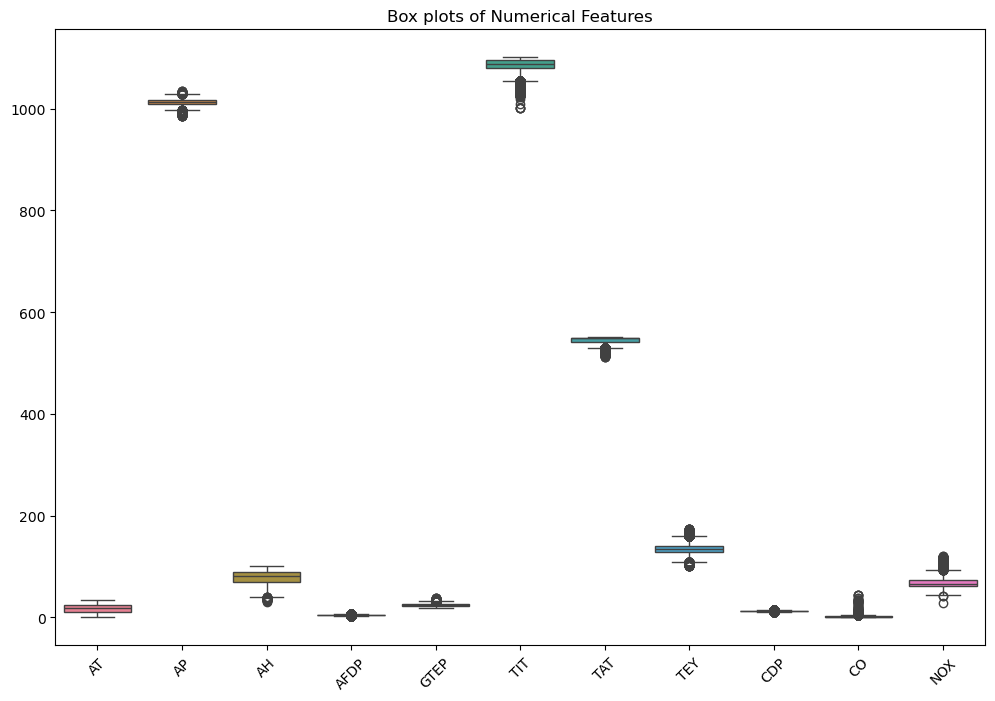

In [3]:
# Create box plots for numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[numerical_features])
plt.title('Box plots of Numerical Features')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(data, features):
    filtered_data = data.copy()
    for feature in features:
        Q1 = np.percentile(filtered_data[feature], 25)
        Q3 = np.percentile(filtered_data[feature], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_data = filtered_data[(filtered_data[feature] >= lower_bound) & (filtered_data[feature] <= upper_bound)]
    return filtered_data

# Remove outliers based on IQR
data = remove_outliers_iqr(data, numerical_features)

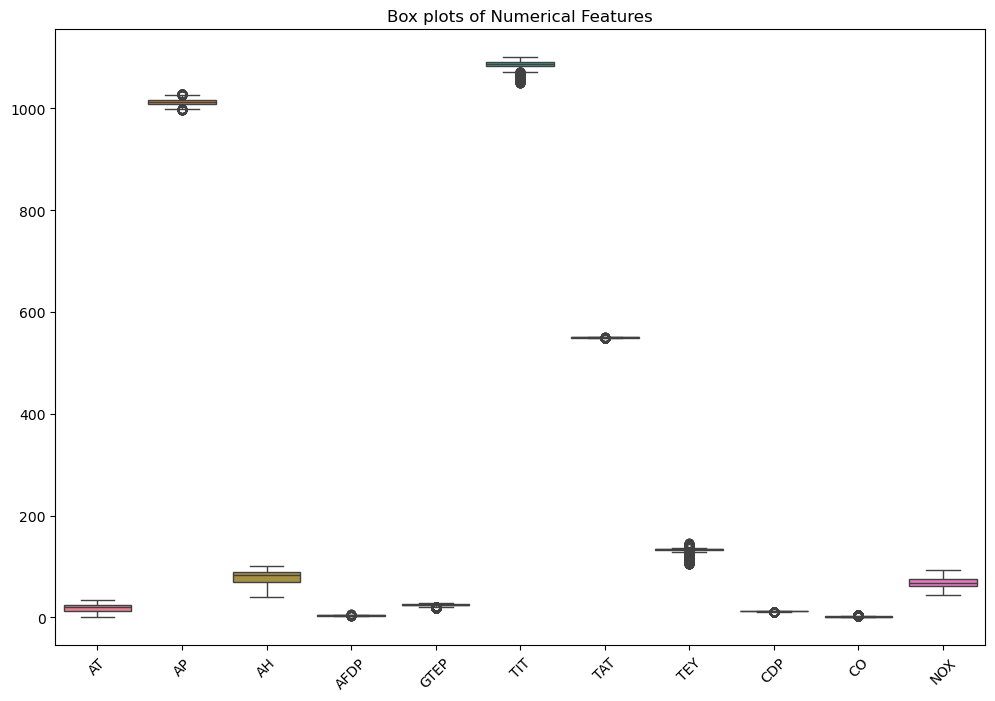

In [5]:
# Create box plots for numerical features without outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[numerical_features])
plt.title('Box plots of Numerical Features')
plt.xticks(rotation=45)
plt.show()

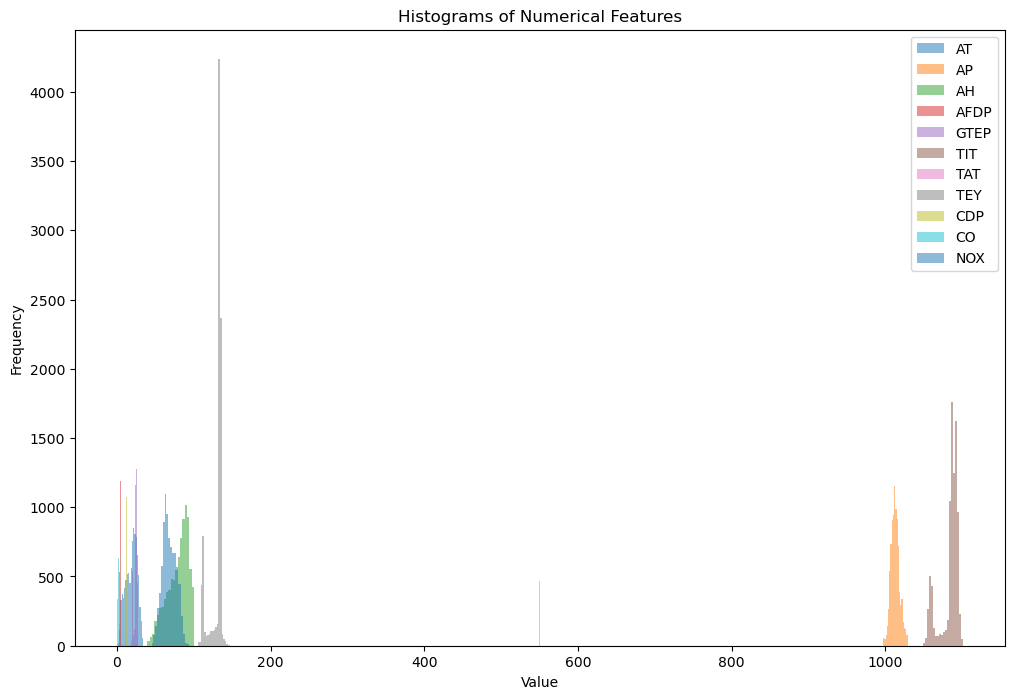

In [6]:
# Histograms for numerical features
plt.figure(figsize=(12, 8))
for feature in numerical_features:
    plt.hist(data[feature], bins=20, alpha=0.5, label=feature)
plt.title('Histograms of Numerical Features')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

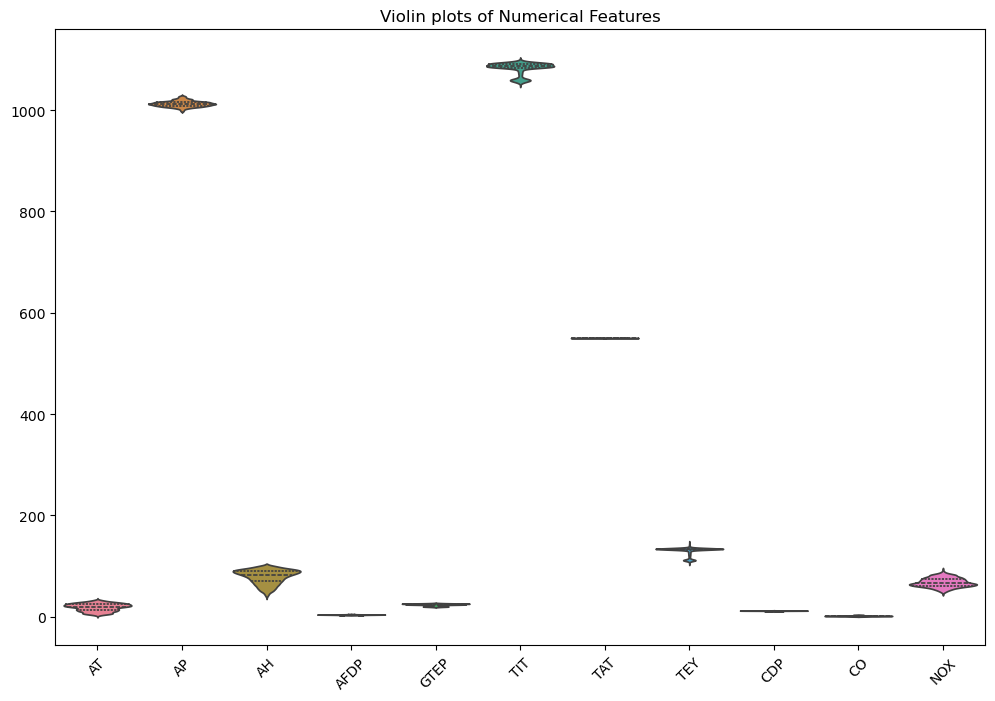

In [7]:
# Violin plots for numerical features
plt.figure(figsize=(12, 8))
sns.violinplot(data=data[numerical_features], inner='quartile')
plt.title('Violin plots of Numerical Features')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

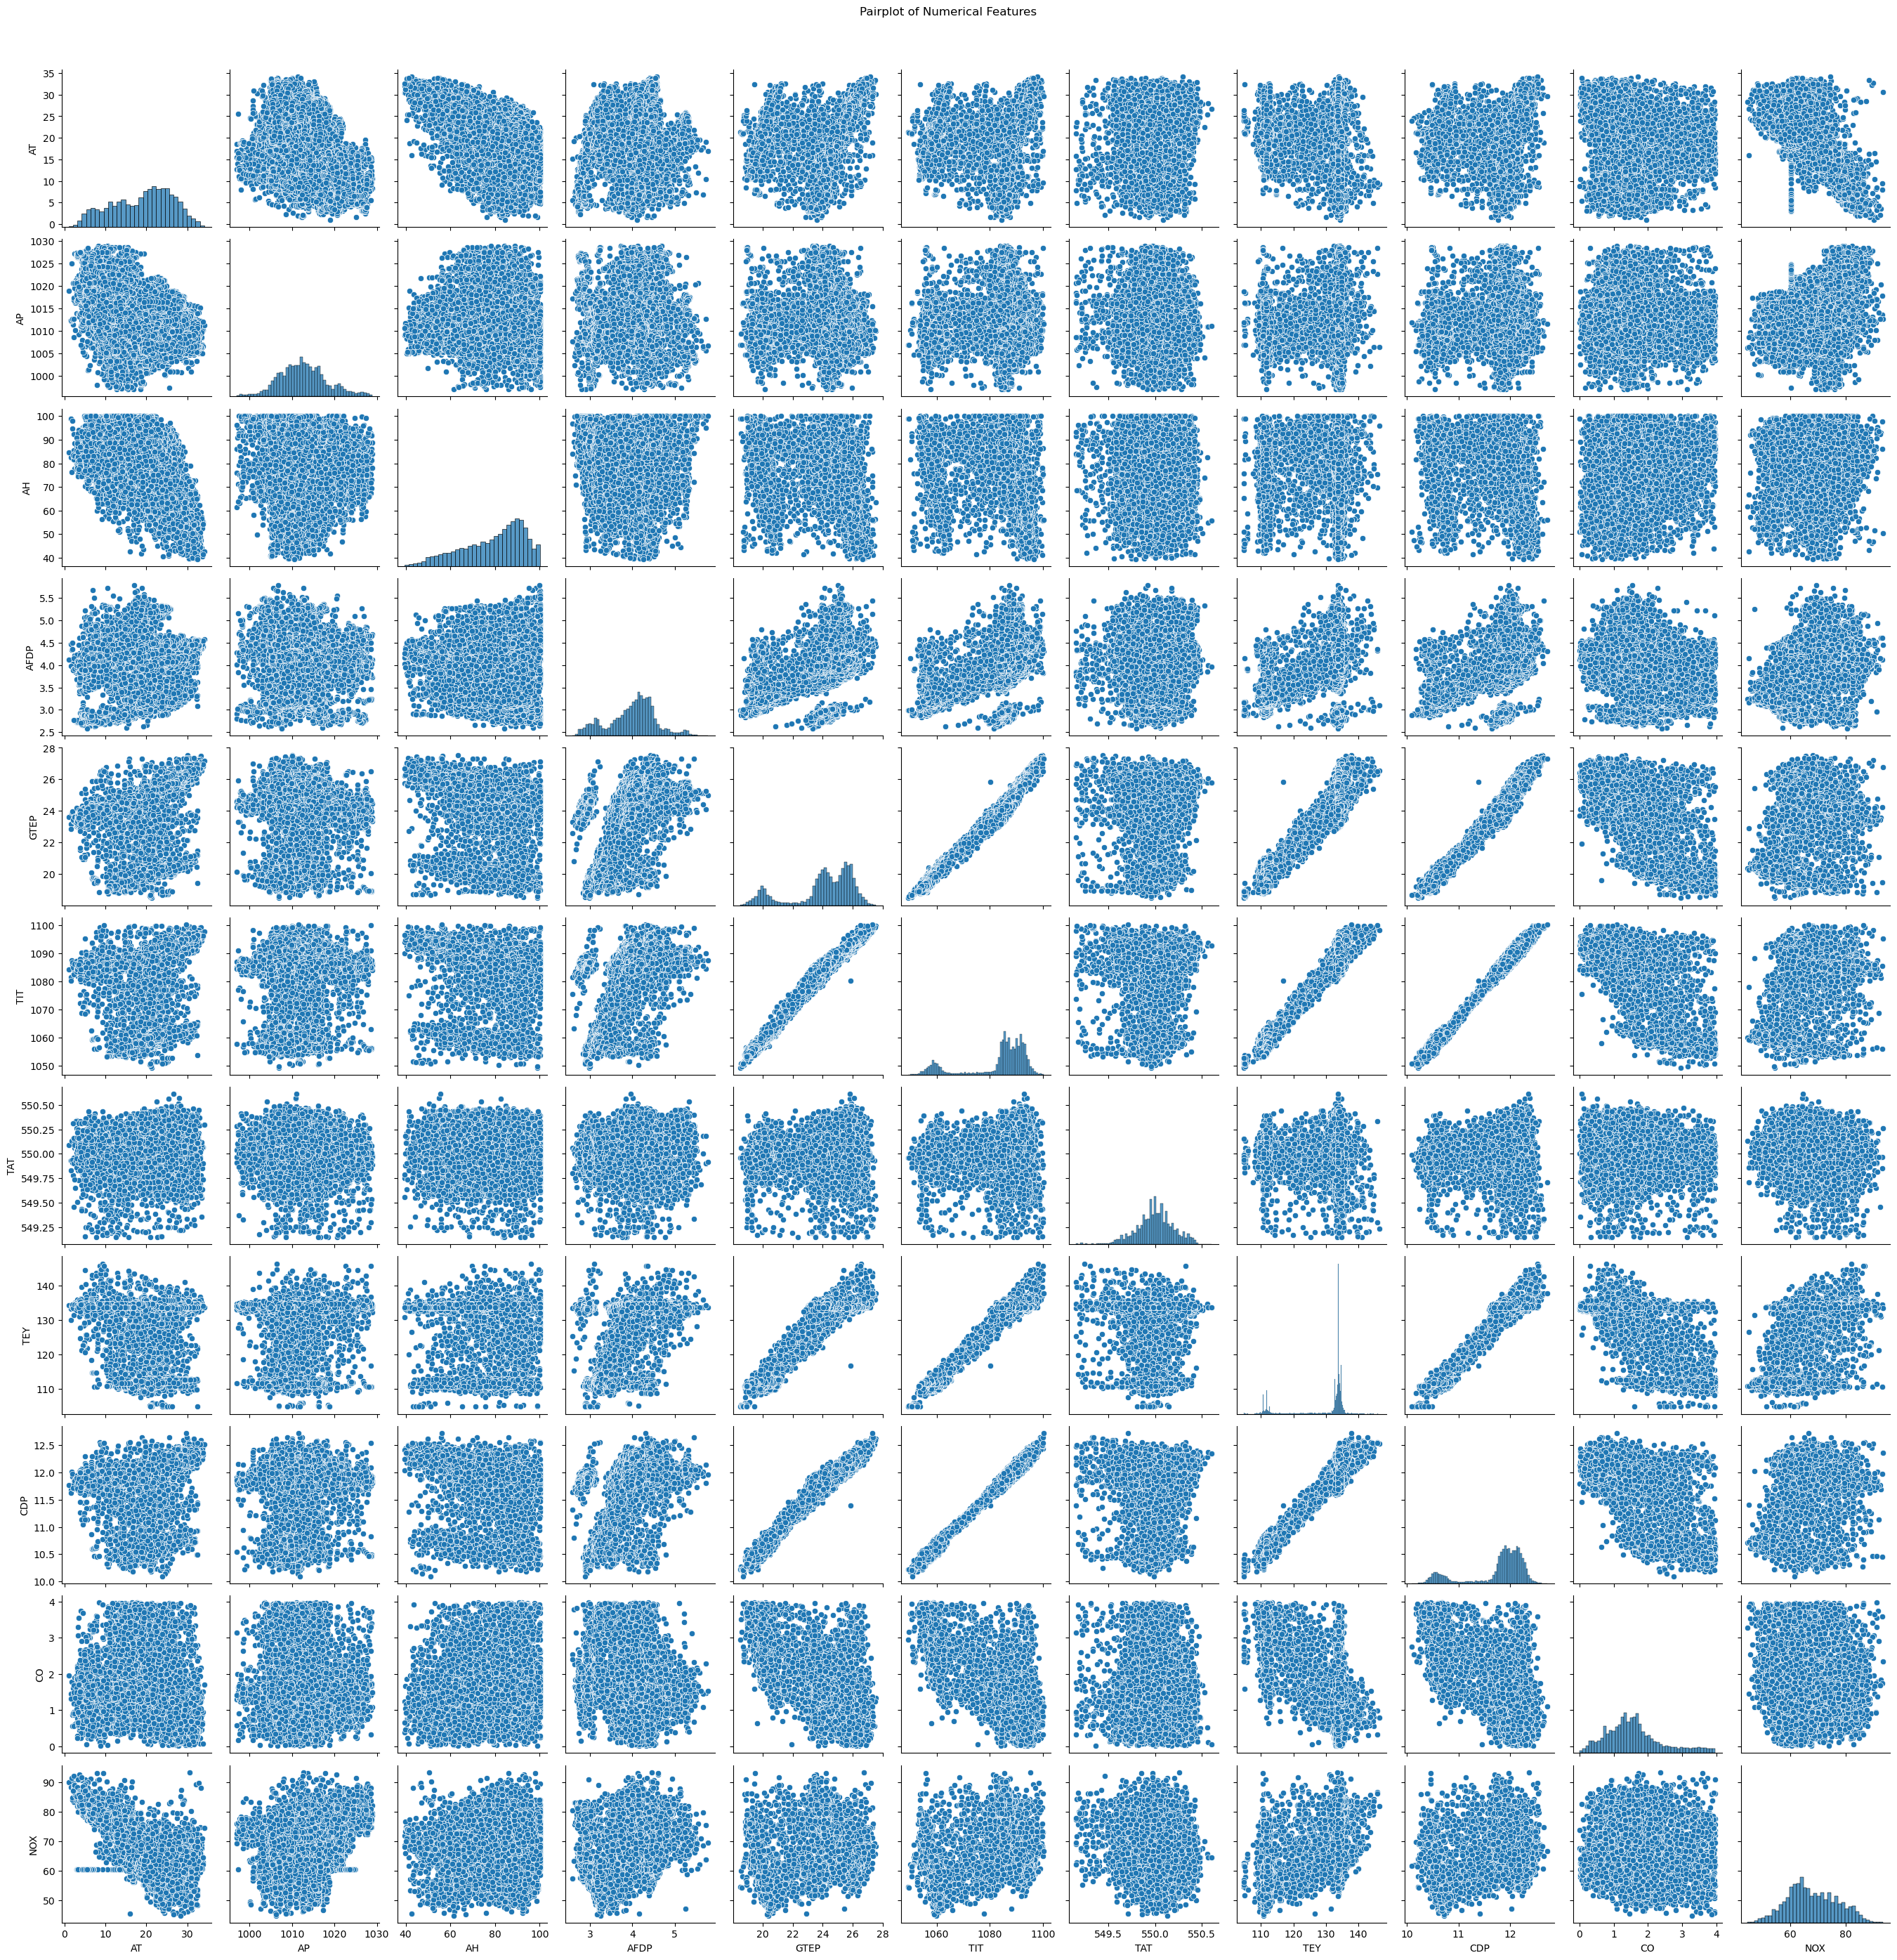

In [8]:
# Pairplot for numerical features after removing outliers
plt.figure(figsize=(12, 8))
sns.pairplot(data[numerical_features])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

In [9]:
# Extract features (ambient variables) and target variable (TEY)
X = data[['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'CDP', 'CO', 'NOX']]
y = data['TEY']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (normalize)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Define a function to create a model
def create_model(activation='relu', neurons_hidden_layer1=64, neurons_hidden_layer2=32, learning_rate=0.001):
    model = keras.Sequential([
        layers.Dense(neurons_hidden_layer1, activation=activation, input_dim=X_train.shape[1]),
        layers.Dense(neurons_hidden_layer2, activation=activation),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, batch_size=16, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'activation': ['relu', 'sigmoid'],
    'neurons_hidden_layer1': [32, 64],
    'neurons_hidden_layer2': [16, 32],
    'learning_rate': [0.01, 0.1],
    'epochs': [5, 10] 
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_result.best_params_)

# Get the best model
best_model = grid_result.best_estimator_

test_loss = best_model.score(X_test, y_test)
print(f'Mean Squared Error on Test Set: {test_loss}')

C:\Users\Sumit\AppData\Local\Temp\ipykernel_18396\1714162463.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, batch_size=16, verbose=0)


Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best parameters found:  {'activation': 'relu', 'epochs': 10, 'learning_rate': 0.01, 'neurons_hidden_layer1': 32, 'neurons_hidden_layer2': 32}
Mean Squared Error on Test Set: -0.6379120349884033


57/57 [==============================] - 0s 1ms/step


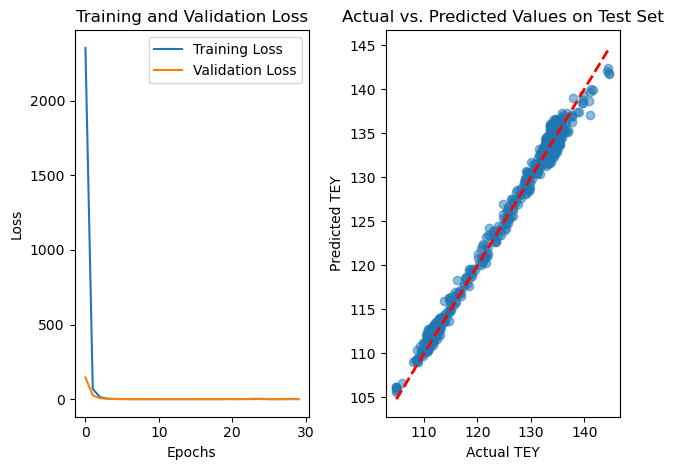

In [11]:
# Get the best parameters found
best_params = grid_result.best_params_
del best_params['epochs']

# Create the best model with the best parameters
best_model = create_model(**best_params)

# Train the best model with all training data
history = best_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

predictions = best_model.predict(X_test)

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot actual vs. predicted values on the test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Values on Test Set')
plt.xlabel('Actual TEY')
plt.ylabel('Predicted TEY')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

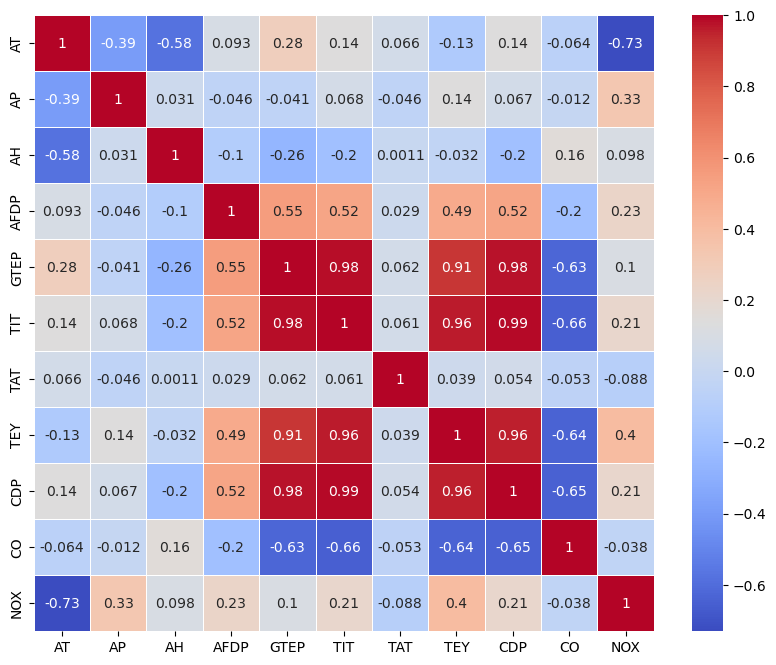

In [12]:
plt.figure(figsize=(12, 8))

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_features].corr(), annot=True, cmap='coolwarm', linewidths=.5)

plt.show()

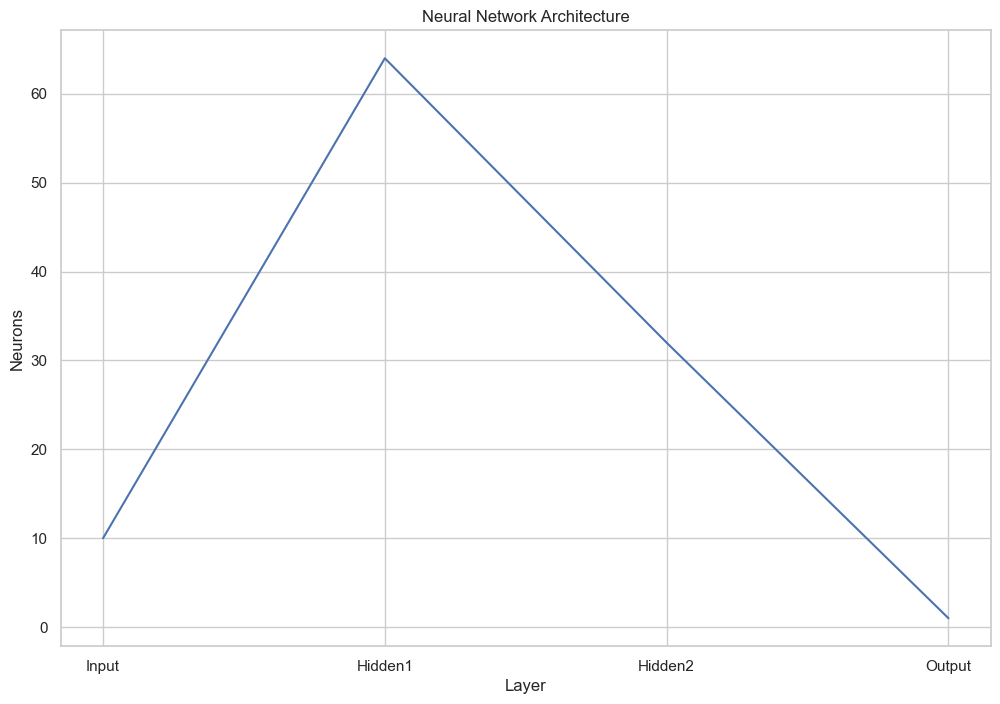

In [14]:
# Visualize the model architecture
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
ax = sns.lineplot(x='Layer', y='Neurons', data=pd.DataFrame({'Layer': ['Input', 'Hidden1', 'Hidden2', 'Output'],
                                                             'Neurons': [X_train.shape[1], 64, 32, 1]}))
ax.set_title('Neural Network Architecture')
plt.show()